In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
import os.path
from loguru import logger
import seaborn as sns
import statsmodels.formula.api as sm

import plotly.graph_objects as go
import datetime
import vaex
from utils import get_human_timestamp
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression
import h5py



In [5]:
def find_beta_for_expiration(data: pd.DataFrame):
    single_expiration = data.copy()
    def get_closest(given_strikes, underlying_price):
    # given_strikes sorted
        for index in range(0, len(given_strikes)-1):
            if given_strikes[index] <= underlying_price and given_strikes[index+1]>=underlying_price:
                return given_strikes[index], given_strikes[index+1]

    def get_mid_mark_iv(forward: float):
        closest_strikes = get_closest(all_covered_strikes, forward)
        return closest_strikes
    
    available_strikes = sorted(single_expiration.strike_price.unique())
    max_value_of_underlying = single_expiration.underlying_price.max()
    min_value_of_underlying = single_expiration.underlying_price.min()
    crossed_strikes = []
    for strike in available_strikes:
        if strike>=min_value_of_underlying and strike<=max_value_of_underlying:
            crossed_strikes.append(strike)

    right_border = get_closest(available_strikes, max_value_of_underlying)[1]
    left_border = get_closest(available_strikes, min_value_of_underlying)[0]

    all_covered_strikes = []
    for strike in available_strikes:
        if strike>=left_border and strike<=right_border:
            all_covered_strikes.append(strike)

    single_expiration["closest_strikes"] = single_expiration["underlying_price"].apply(get_mid_mark_iv)
    single_expiration["left_border"] = single_expiration["closest_strikes"].apply(lambda x: x[0])
    single_expiration["right_border"] = single_expiration["closest_strikes"].apply(lambda x: x[1])

    df_of_only_needed_strikes = single_expiration[single_expiration["strike_price"].isin(all_covered_strikes)]
    df_of_only_needed_strikes = df_of_only_needed_strikes[["timestamp", "strike_price", "mark_iv"]].drop_duplicates().copy()
    
    df_of_only_needed_strikes_left = df_of_only_needed_strikes.copy()
    df_of_only_needed_strikes_left = df_of_only_needed_strikes_left.rename(columns = {"mark_iv": "mark_iv_left"})
    single_expiration = single_expiration.merge(df_of_only_needed_strikes_left, how = "left", 
                                                left_on = ["timestamp", "left_border"], right_on = ["timestamp", "strike_price"])

    df_of_only_needed_strikes_right = df_of_only_needed_strikes.copy()
    df_of_only_needed_strikes_right = df_of_only_needed_strikes_right.rename(columns = {"mark_iv": "mark_iv_right"})
    single_expiration = single_expiration.merge(df_of_only_needed_strikes_right, how = "left", 
                                                left_on = ["timestamp", "right_border"], right_on = ["timestamp", "strike_price"])

    single_expiration = single_expiration.drop(columns = ["strike_price_y", "strike_price"])
    single_expiration = single_expiration.rename(columns = {"strike_price_x": "strike_price"})
    
    single_expiration["mark_iv_left"] = single_expiration["mark_iv_left"].fillna(method='ffill')
    single_expiration["mark_iv_right"] = single_expiration["mark_iv_right"].fillna(method='ffill')
    
    only_needed = single_expiration[["timestamp", "underlying_price", "right_border", "left_border",
                                  "mark_iv_left", "mark_iv_right", "strike_price", "mark_iv"]].copy()
    only_needed = only_needed.dropna()
    only_needed = only_needed[only_needed["strike_price"].isin(all_covered_strikes)]


    only_needed["ATM_iv"] = only_needed["mark_iv_left"] * (only_needed["right_border"]-only_needed["underlying_price"])/(
            only_needed["right_border"] - only_needed["left_border"]) + only_needed["mark_iv_right"] * (only_needed["underlying_price"] - only_needed["left_border"])/(
    only_needed["right_border"] - only_needed["left_border"])

    only_needed["ln_underlying_price"] = np.log(only_needed["underlying_price"])
    only_needed["ln_ATM_iv"] = np.log(only_needed["ATM_iv"])
    to_fit = only_needed[["ln_underlying_price", "ln_ATM_iv"]].drop_duplicates().copy()
    
    lr = LinearRegression()
    lr.fit(to_fit["ln_underlying_price"].values.reshape(-1, 1), to_fit["ln_ATM_iv"])
    k = lr.coef_[0]
    alpha = lr.intercept_
    beta = k+1
#     xx = np.linspace(to_fit["ln_underlying_price"].max(), to_fit["ln_underlying_price"].min(), 100)
#     yy = k*xx + alpha
#     plt.scatter(to_fit["ln_underlying_price"], to_fit["ln_ATM_iv"])
#     plt.plot(xx, yy, color = "orange")
    
#     results = sm.ols(formula='ln_ATM_iv~ln_underlying_price', data = to_fit).fit()
#     results.summary()
    
    return beta
    

In [6]:
def select_data(df: pd.DataFrame, currency: str  = "BTC"):
    # take single currency
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    data = df[ind].reset_index(drop=True)
    #tau is time before expiration in years
    data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365
    #days before exp
    data['days'] = (data['tau'] * 365).astype(int)
    # find beta for each expiration
    
    data["human_expiration"] = data["expiration"]\
    .apply(lambda x : datetime.datetime.fromtimestamp(x/1000000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))

    K = data.strike_price.values
    F = data.underlying_price.values

    payoff = np.maximum(F - K, 0.0)
    payoff[data.type == 'put'] = np.maximum( K - F, 0.0)[data.type == 'put']
    data["payoff"] = payoff
    
    #inverse 
    data["inverse_payoff"] =  data["payoff"]/data["underlying_price"]
    
    data['mid_price'] = 0.5 * (data.ask_price + data.bid_price)
    
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)

    # отбираем тольеко не истекшие
    put = data_grouped[data_grouped.type == 'put'].drop(['type'], axis=1).reset_index(drop=True)
    put = put[put["days"] > 0] 
    
    call = data_grouped[data_grouped.type == 'call'].drop(['type'], axis=1).reset_index(drop=True)
    call = call[call["days"] > 0] 
    
    return put, call

# Калибровка

In [7]:
class SABR:
    def __init__(self, data: pd.DataFrame, beta: float = 0.5) -> None:
        """Class to model the volatility smile"""
        self.data = data
        # let it be fixed as in the artice
        self.beta = beta
        self.T = data.iloc[0].tau
        #Change by milliseconds, but we need similar
        self.underlying_price = data.iloc[0].underlying_price
        # start params for optimization
        self.x0 = np.array([0.99, 0.00, 0.99])
        self.bounds = [(0.0001, 1000.0), (-0.9999, 0.9999), (0.0001, 1000.0)]


    def _sigmaB(
        self, f: float, K: float, T: float, alpha: float, rho: float, v: float
    ) -> float:
        """Function to count modeled volatility"""
        first_part_of_numerator = (
            (1 - self.beta) ** 2 / 24 * alpha**2 / (f * K) ** (1 - self.beta)
        )
        second_part_of_numerator = (
            (rho * self.beta * v * alpha) / 4 * (f * K) ** ((1 - self.beta) / 2)
        )
        third_part_of_numerator = (2 - 3 * rho**2) * v**2 / 24
        numerator = alpha * (
            1
            + self.T
            * (
                first_part_of_numerator
                + second_part_of_numerator
                + third_part_of_numerator
            )
        )

        first_part_of_denominator = (1 - self.beta) ** 2 / 24 * (np.log(f / K)) ** 2
        second_part_of_denominator = (1 - self.beta) ** 4 / 1920 * (np.log(f / K)) ** 4
        denominator = (f * K) ** ((1 - self.beta) / 2) * (
            1 + first_part_of_denominator + second_part_of_denominator
        )

        z = v / alpha * (f * K) ** ((1 - self.beta) / 2) * np.log(f / K)

        xi = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))

        return numerator / denominator * z / xi

    def _plot_results(self) -> None:
        """Function to plot results"""

        def get_sigmas_for_set_of_params(alpha: float, rho: float, v: float) -> None:
            """Inner function to count sigmas for current optimization method"""
            self.volatilities = []
            self.test_strikes = np.linspace(500, 5000, 100)
            for strike in self.test_strikes:
                sigma_modeled = self._sigmaB(
                    self.underlying_price, strike, self.T, alpha, rho, v
                )
                self.volatilities.append(sigma_modeled)

        get_sigmas_for_set_of_params(
            self.alpha_scipy, self.rho_scipy, self.v_scipy
        )

        fig, ax = plt.subplots(figsize=(20, 7))
        ax = sns.scatterplot(x = "strike_price", y = "mark_iv", data=self.data, 
                             color = "black",
                             label="scipy optimizer")

        ax1 = sns.lineplot(
            x=self.test_strikes,
            y=self.volatilities,
            label="market volatilities",
            color="blue",
        ).set_title(f"T = {int(self.T * 365)} days")

    def _vol_square_error(self, x: np.ndarray) -> np.float64:
        """Function to get the argmin function we want to optimize"""
        # init market volatiliteis
        smile = self.data.mark_iv.to_numpy()
        vols = []
        for index, row in self.data.iterrows():
            vols.append(
                self._sigmaB(
                    self.underlying_price, row["strike_price"], self.T, x[0], x[1], x[2]
                )
            )
        return sum((vols - smile) ** 2)


    def _minimize_scipy(self) -> np.float64:
        """Optimization with scipy optimizer"""
        return minimize(self._vol_square_error, x0=self.x0,  bounds = self.bounds)

    def run(self) -> None:
        """Run optimization and plot results"""
        # optimization via scipy
        optimum_scipy = self._minimize_scipy()
        self.alpha_scipy, self.rho_scipy, self.v_scipy = optimum_scipy.x
        logger.info(
            f"""Optimal params for T = {int(self.T*365)} days: alpha = {self.alpha_scipy}, rho = {self.rho_scipy}, v = {self.v_scipy}
            beta = {self.beta}"""
        )
        # plot market values and modeled function
        self._plot_results()
        return self.volatilities, self.alpha_scipy, self.beta, self.rho_scipy, self.v_scipy, self.T


In [8]:
#days before exp
# симуляци по чистым данным
df = pd.read_csv(f"./datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
currency = "ETH"
put, call = select_data(df, currency=currency)
days = sorted(list(set(call.days.values)))
print(f"Expiration dates: {days}") 

df = df[df["symbol"].str.startswith(currency)]
columns = ["symbol", "timestamp", "type", "strike_price", "expiration", "bid_price", 
                   "ask_price", "mark_price", "mark_iv", "underlying_price"]
df = df[columns]
df['days'] = ((df.expiration - df.timestamp) / 1e6 / 3600 / 24).astype(int)
df = df[df["days"].isin(days)]

Expiration dates: [1, 7, 14, 21, 28, 56, 84, 119, 210, 301]


2023-02-04 20:19:53.149 | INFO     | __main__:run:100 - Optimal params for T = 28 days: alpha = 796.209099354945, rho = -1.6829038800783883e-05, v = 35.68931156830166
            beta = 0.3590875978589466


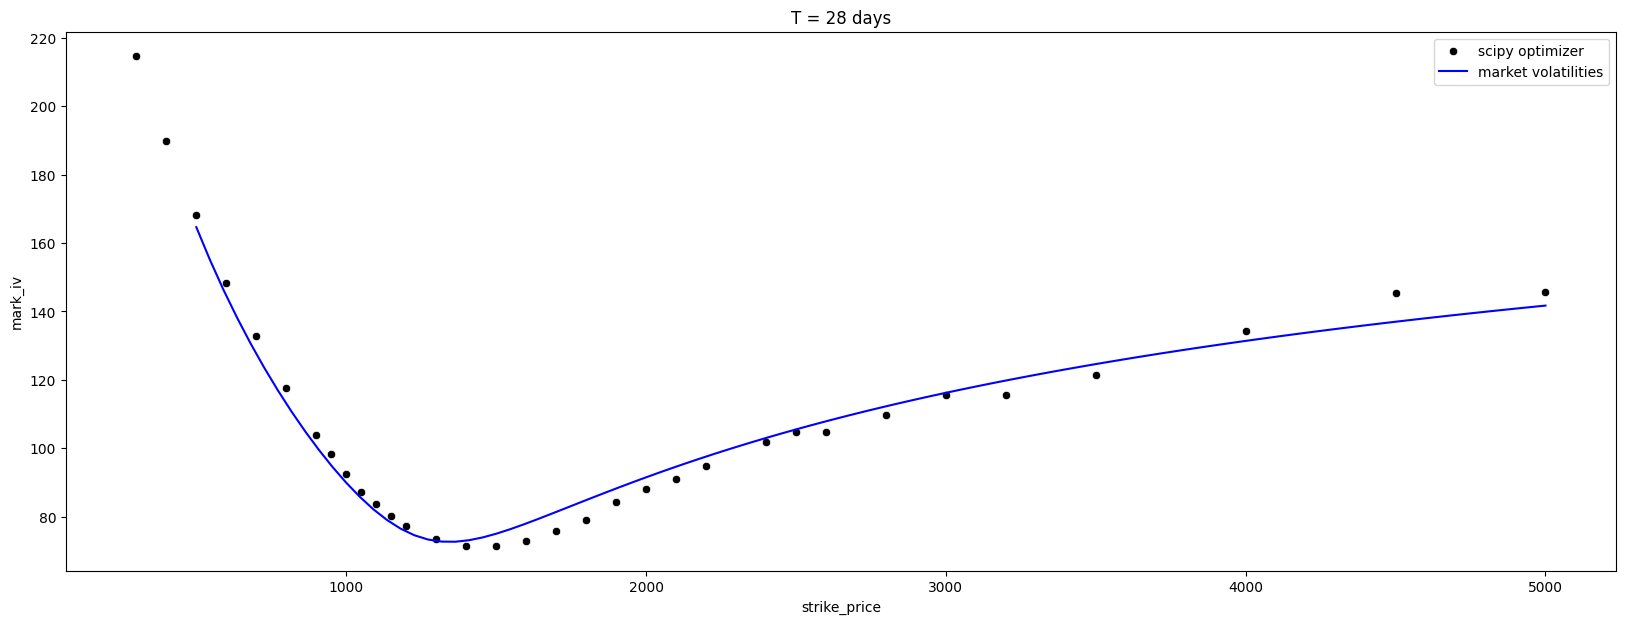

In [9]:
# выкидываем из выборки опционы, которые deep ITM
list_of_vols = []
alphas = []
betas = []
rhos = []
vs = []
Ts = []
for day in days:
    # с близкими к экспирации пока не очень
    if day not in [28]:
        continue
    # считаем beta для каждой даты экспирации отдельно
    beta = find_beta_for_expiration(df[df["days"] == day])
    call_ = call[call.days == day]
    put_ = put[put.days == day]
    
    cc = call_[call_["strike_price"]>=call_["underlying_price"]]
    pp = put_[put_["strike_price"]<=put_["underlying_price"]]
    dff = pd.concat([cc, pp])
    
    dff.to_pickle("28.pkl")
    
    dff = dff[dff["strike_price"]<=5000]
    # подставляем найденное beta
    sabr = SABR(dff, beta=beta)
#     sabr = SABR(cc)
    vols, alpha, beta, rho, v, T = sabr.run()
    list_of_vols.append(vols)
    alphas.append(alpha)
    betas.append(beta)
    rhos.append(rho)
    vs.append(v)
    Ts.append(T)

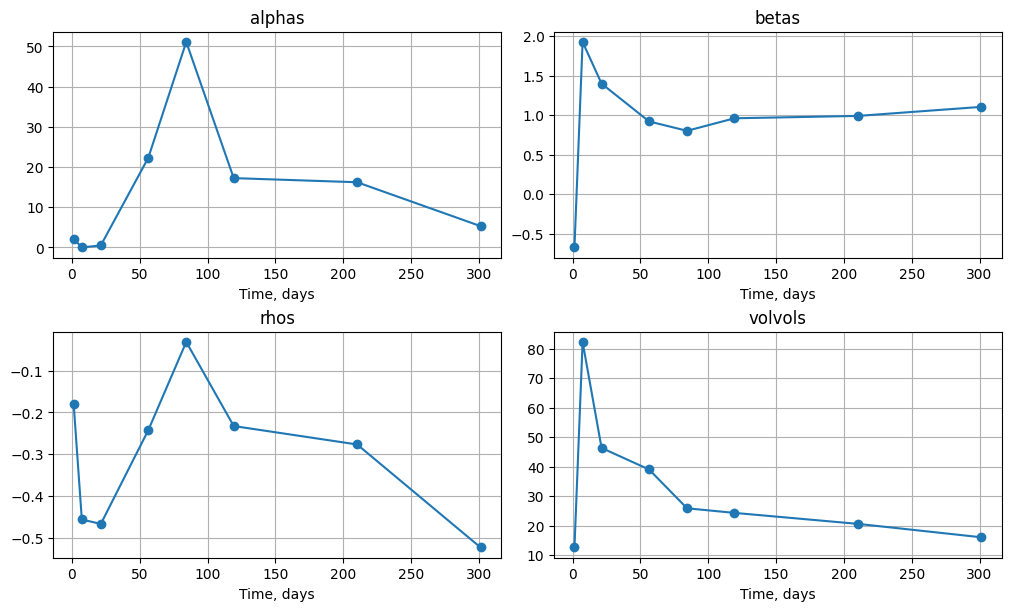

In [27]:
Ts_days = np.array(Ts)*365
fig, axs = plt.subplots(2, 2, figsize=(10, 6), constrained_layout=True)
x_axis_name = 'Time, days'
axs[0, 0].plot(Ts_days, alphas, 'o', ls='-')
axs[0, 0].set_xlabel(x_axis_name)
axs[0, 0].set_title("alphas")
axs[0, 0].grid()

axs[0, 1].plot(Ts_days, betas, 'o', ls='-')
axs[0, 1].set_xlabel(x_axis_name)
axs[0, 1].set_title("betas")
axs[0, 1].grid()

axs[1, 0].plot(Ts_days, rhos, 'o', ls='-')
axs[1, 0].set_xlabel(x_axis_name)
axs[1, 0].set_title("rhos")
axs[1, 0].grid()

axs[1, 1].plot(Ts_days, vs, 'o', ls='-')
axs[1, 1].set_xlabel(x_axis_name)
axs[1, 1].set_title("volvols")
axs[1, 1].grid()


In [29]:
x, y, z = np.linspace(500, 5000, 100), days, np.array(list_of_vols)
sh_0, sh_1 = z.shape
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True), 
                 )

fig.update_layout(title='Volatility surface', autosize=False,
                  width=1000, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                 scene=dict(
        xaxis_title='Strike, $',
        yaxis_title='Maturite, days',
        zaxis_title='Volatility',
    )
                  
                 )
fig.show()